In [2]:
:dep plotters = { version = "0.3.4", default_features = false, features = ["evcxr", "all_series"] }
:dep rand = "0.8.5"
:dep micrograd_rs = { path = "." }

use std::f64;
use std::iter::zip;
use rand::distributions::{Distribution, Uniform};
use plotters::prelude::*;
use micrograd_rs::engine::Value;
use micrograd_rs::nn::{ActFunc, MLP, Module};

In [3]:
/* Training data */

const TRAINSET_SIZE: usize = 100;

// Two interleaving half circles.
// https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html
// from sklearn.datasets import make_moons
// x, y = make_moons(n_samples=100, noise=0.1)
// y = y*2 - 1 # make y be -1 or 1
let x = [
    [ 0.21900425, -0.31928064],
    [-0.2433641 ,  1.25428878],
    [ 1.39725614, -0.51126709],
    [ 0.67560314, -0.29258939],
    [ 0.66684919,  0.92844791],
    [-0.92587874,  0.2861894 ],
    [ 2.08515435,  0.08058096],
    [-0.81702975,  0.40029491],
    [ 1.96401779,  0.07062186],
    [ 0.1321024 ,  0.44397071],
    [ 0.11730194,  0.94167338],
    [ 0.85081982, -0.62860842],
    [ 1.25295217, -0.7276565 ],
    [-0.50984904,  0.81316953],
    [-0.03653157,  0.97414679],
    [-0.9485794 ,  0.78646369],
    [ 0.8661971 ,  0.13394775],
    [ 0.88417162,  0.33696685],
    [-1.05851904, -0.14663054],
    [-0.75611868,  0.96365265],
    [ 1.50018185, -0.25295473],
    [-0.79023591,  0.25588464],
    [-1.01678435,  0.19689327],
    [ 0.98605152, -0.03770924],
    [ 1.48417117, -0.5673026 ],
    [-0.98317567,  0.50238025],
    [ 1.06824624,  0.34331557],
    [ 0.0161936 ,  0.17749694],
    [ 1.31118909, -0.46242167],
    [ 0.26089773, -0.12263417],
    [ 2.0663111 ,  0.12887874],
    [-0.93470338,  0.13446922],
    [ 0.39684683, -0.0727316 ],
    [ 0.71709127,  0.43936978],
    [-0.31413567,  0.95859448],
    [ 1.72963631, -0.19179626],
    [ 1.70707814, -0.19115507],
    [-0.93421103,  0.15994392],
    [ 1.33288515, -0.5285524 ],
    [-0.65946079,  0.69404333],
    [-0.78178497,  0.66179162],
    [ 0.46017319,  1.01830291],
    [-0.04198916,  0.66738443],
    [ 0.23168443,  1.01088968],
    [ 0.753791  ,  0.8387005 ],
    [ 0.76955872,  0.58744858],
    [ 0.13088239,  0.92427887],
    [ 1.06063159, -0.51352756],
    [ 0.27035654,  0.9102704 ],
    [ 0.66118583, -0.42687533],
    [ 1.80312246, -0.25262072],
    [-0.03538346,  0.52590017],
    [ 1.56026394, -0.52512469],
    [ 1.92992273, -0.01362268],
    [-0.35941881,  0.84993419],
    [ 0.78204278,  0.52771353],
    [ 0.0153407 ,  1.00804355],
    [ 0.68881857,  0.6020938 ],
    [ 0.62846607,  0.74843212],
    [ 2.07682789,  0.66354635],
    [-0.08648267,  1.11355965],
    [ 0.88365603, -0.51278238],
    [ 0.6634087 , -0.59576393],
    [-0.03391126,  0.88894327],
    [ 0.5057841 , -0.4433224 ],
    [ 0.56085335,  0.63597061],
    [ 2.06194936,  0.18378294],
    [ 0.15689022, -0.1678817 ],
    [ 0.13994147, -0.05006431],
    [ 1.62051896,  0.03998433],
    [-0.11694741,  0.05723511],
    [ 1.7960194 , -0.04454546],
    [ 0.27401977, -0.01848482],
    [ 1.12886918, -0.5052335 ],
    [ 0.08058377,  0.2163684 ],
    [-0.46465717,  0.91510444],
    [ 1.06137805, -0.17190325],
    [-0.84750907,  0.68425604],
    [ 0.63152731, -0.37653834],
    [-0.0197884 ,  1.01072437],
    [ 1.1727178 , -0.54428117],
    [ 0.52592297,  0.98123117],
    [-0.30993935,  0.77009494],
    [ 0.46451806, -0.54998759],
    [-0.98920813,  0.30395816],
    [ 0.24264716, -0.03608822],
    [-0.15362595,  1.00209808],
    [ 0.16852448,  0.02913557],
    [ 0.92360115,  0.20556849],
    [-0.89930998,  0.41253356],
    [-0.5881296 ,  0.9022792 ],
    [ 0.91017212,  0.02686779],
    [ 1.95489695,  0.58845136],
    [ 1.38786163, -0.59885723],
    [ 0.64184591,  0.69021188],
    [ 0.04592228,  0.26792419],
    [ 0.48080647, -0.49715947],
    [ 1.902633  ,  0.27265993],
    [ 2.08577769, -0.14909862],
    [ 1.82035854, -0.06292139]];

let y = [
     1.0, -1.0,  1.0,  1.0, -1.0, -1.0,  1.0, -1.0,  1.0,  1.0, -1.0,  1.0,  1.0,
    -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0,  1.0, -1.0, -1.0, -1.0,  1.0, -1.0,
    -1.0,  1.0,  1.0,  1.0,  1.0, -1.0,  1.0, -1.0, -1.0,  1.0,  1.0, -1.0,  1.0,
    -1.0, -1.0, -1.0,  1.0, -1.0, -1.0, -1.0, -1.0,  1.0, -1.0,  1.0,  1.0,  1.0,
     1.0,  1.0, -1.0, -1.0, -1.0, -1.0, -1.0,  1.0, -1.0,  1.0,  1.0, -1.0,  1.0,
    -1.0,  1.0,  1.0,  1.0,  1.0,  1.0,  1.0,  1.0,  1.0,  1.0, -1.0, -1.0, -1.0,
     1.0, -1.0,  1.0, -1.0, -1.0,  1.0, -1.0,  1.0, -1.0,  1.0, -1.0, -1.0, -1.0,
    -1.0,  1.0,  1.0, -1.0,  1.0,  1.0,  1.0,  1.0,  1.0];

In [4]:
/* Visualize training data */

evcxr_figure((640, 480), |root| {
    // Separate into two datasets according to y-value.
    let mut data1: Vec<&[f64; 2]> = Vec::new();
    let mut data2: Vec<&[f64; 2]> = Vec::new();
    
    for (i, d) in y.iter().enumerate() {
        if *d == 1.0 {
            data1.push(&x[i]);
        } else {
            data2.push(&x[i]);
        }
    }

    let mut chart = ChartBuilder::on(&root)
        .margin(5)
        .x_label_area_size(40)
        .y_label_area_size(40)
        .build_cartesian_2d(-1.5f64..2.5f64, -1f64..1.5f64)?;
    
    chart.configure_mesh()
        .disable_x_mesh()
        .disable_y_mesh()
        .draw()?;
    
    chart.draw_series(data1.iter().map(|[x, y]| Circle::new((*x,*y), 3, RED.filled())))?;
    chart.draw_series(data2.iter().map(|[x, y]| Circle::new((*x,*y), 3, BLUE.filled())))?;
    Ok(())
})

-1.0
 
 
 
-0.5
 
 
 
0.0
 
 
 
0.5
 
 
 
1.0
 
 
 
1.5
 
 
 
 
-1.5
 
 
 
-1.0
 
 
 
-0.5
 
 
 
0.0
 
 
 
0.5
 
 
 
1.0
 
 
 
1.5
 
 
 
2.0
 
 
 
2.5

In [5]:
/* Initialize a model */

// 2-layer neural network.
let model = MLP::new(2, &[16, 16, 1], ActFunc::ReLU);
println!("{}", model);
println!("Number of parameters: {}", model.parameters().len());

MLP of [[Layer of [[ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2)]], Layer of [[ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16)]], Layer of [[LinearNeuron(16)]]]]
Number of parameters: 337


In [6]:
/* Loss function */

fn loss(model: &MLP,
        x: &[[f64; 2]; TRAINSET_SIZE],
        y: &[f64; TRAINSET_SIZE],
        batch_size: Option<usize>) -> (Value, f64) {

    let mut xb: Vec<[f64; 2]> = Vec::new();
    let mut yb: Vec<f64> = Vec::new();

    // Inline DataLoader.
    if let Some(size) = batch_size {
        let mut rng = rand::thread_rng();
        let range = Uniform::from(0..x.len());
        let ri: Vec<usize> = range.sample_iter(&mut rng).take(size).collect();
        for i in ri {
            xb.push(x[i]);
            yb.push(y[i]);
        }
    } else {
        (xb, yb) = (x.to_vec(), y.to_vec());
    }

    // Convert inputs of f64 to Value.
    let inputs: Vec<Vec<Value>> = xb.iter().map(|xrow| vec![Value::new(xrow[0]), Value::new(xrow[1])]).collect();

    // Forward the model to get scores.
    let mut scores: Vec<Vec<Value>> = Vec::new();
    let scores: Vec<Value> = inputs.iter().map(|val| model.forward(&val)[0].clone()).collect();

    // SVM "max-margin" loss.
    let losses: Vec<Value> = zip(yb.iter(), scores.iter())
        .map(|(yi, scorei)| (1.0 + -yi * scorei).relu())
        .collect();

    let sum_losses = losses.iter().fold(Value::new(0.0), |a, b| &a + b);
    let data_loss = sum_losses * (1.0 / losses.len() as f64);

    // L2 regularization.
    let alpha = 1e-4;
    let reg_loss = alpha * model.parameters().iter().fold(Value::new(0.0), |a, b| a * b.clone());
    let total_loss = data_loss + reg_loss;

    // Also get accuracy.
    let accuracy: Vec<bool> = zip(yb, scores).map(|(yi, scorei)| (yi > 0.0) == (scorei.get_data() > 0.0)).collect();
    let sum_accuracy = accuracy.iter().filter(|&n| *n).count();

    (total_loss, sum_accuracy as f64 / accuracy.len() as f64)
}

In [7]:
/* Training */

for k in 0..100 {
    // Forward.
    let (total_loss, acc) = loss(&model, &x, &y, None);

    // Backward
    model.zero_grad();
    total_loss.backward();

    // Update (sgd).
    let learning_rate = 1.0 - 0.9 * k as f64 / 100.0;
    for p in model.parameters() {
        p.set_data(p.get_data() - learning_rate * p.get_grad());
    }

    println!("step {} loss {} accuracy {}%", k, total_loss.get_data(), acc * 100.0);
};

step 0 loss 2.081423906144612 accuracy 50%
step 1 loss 5.04734908541255 accuracy 50%
step 2 loss 0.8264929648407312 accuracy 60%
step 3 loss 0.5741012472810145 accuracy 78%
step 4 loss 0.3751211356259688 accuracy 82%
step 5 loss 0.3070960236489989 accuracy 84%
step 6 loss 0.29754747816927 accuracy 84%
step 7 loss 0.370407077872233 accuracy 86%
step 8 loss 0.2720253293051833 accuracy 86%
step 9 loss 0.22282356085891927 accuracy 91%
step 10 loss 0.19600381436669304 accuracy 90%
step 11 loss 0.2802003003750203 accuracy 93%
step 12 loss 0.25282995337102615 accuracy 89%
step 13 loss 0.5590445842897649 accuracy 87%
step 14 loss 0.13665649209602534 accuracy 96%
step 15 loss 0.06971888969775547 accuracy 98%
step 16 loss 0.04932507416053526 accuracy 99%
step 17 loss 0.04613601409225726 accuracy 98%
step 18 loss 0.03608946183871041 accuracy 99%
step 19 loss 0.031639462806924264 accuracy 99%
step 20 loss 0.02614917769622971 accuracy 100%
step 21 loss 0.019376544485247577 accuracy 100%
step 22 los

In [8]:
/* Visualize decision boundary */

// Doing NumPy operations manually in this section.

// h = 0.25
// x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
// y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
let x_col: Vec<f64> = x.iter().map(|v| v[0]).collect();
let y_col: Vec<f64> = x.iter().map(|v| v[1]).collect();
let x_min = x_col.iter().fold(f64::INFINITY, |a, &b| a.min(b)) - 1.0;
let x_max = x_col.iter().fold(f64::NEG_INFINITY, |a, &b| a.max(b)) + 1.0;
let y_min = y_col.iter().fold(f64::INFINITY, |a, &b| a.min(b)) - 1.0;
let y_max = y_col.iter().fold(f64::NEG_INFINITY, |a, &b| a.max(b)) + 1.0;

// xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
let h = 0.25;
let mut x_range: Vec<f64> = Vec::new();
let mut y_range: Vec<f64> = Vec::new();

let mut tmp = x_min;
while tmp < x_max {
    x_range.push(tmp);
    tmp += h;
}

tmp = y_min;
while tmp < y_max {
    y_range.push(tmp);
    tmp += h;
}

let mut xx: Vec<Vec<f64>> = Vec::new();
let mut yy: Vec<Vec<f64>> = Vec::new();
for (i, e) in y_range.iter().enumerate() {
    xx.push(x_range.clone());
    yy.push(vec![y_range[i]; x_range.len()]);
}

// Xmesh = np.c_[xx.ravel(), yy.ravel()]
let mut xx_ravel: Vec<f64> = Vec::new();
let mut yy_ravel: Vec<f64> = Vec::new();
for row in &xx {
    for v in row {
        xx_ravel.push(*v);
    }
}
for row in &yy {
    for v in row {
        yy_ravel.push(*v);
    }
}
let mut xmesh: Vec<Vec<f64>> = Vec::new();
for (i, yval) in yy_ravel.iter().enumerate() {
    xmesh.push(vec![xx_ravel[i], *yval]);
}

// inputs = [list(map(Value, xrow)) for xrow in Xmesh]
// scores = list(map(model, inputs))
let inputs: Vec<Vec<Value>> = xmesh.iter().map(|xrow| vec![Value::new(xrow[0]), Value::new(xrow[1])]).collect();
let scores: Vec<Value> = inputs.iter().map(|val| model.forward(&val)[0].clone()).collect();

// Z = np.array([s.data > 0 for s in scores])
// Z = Z.reshape(xx.shape)
let zvalues: Vec<bool> = scores.iter().map(|s| s.get_data() > 0.0).collect();
let mut z: Vec<Vec<bool>> = Vec::new();
let mut chunk_start = 0;
let chunk_len = xx[0].len();
while chunk_start < zvalues.len() {
    z.push(zvalues[chunk_start..chunk_start + chunk_len].to_vec());
    chunk_start += chunk_len;
};

// xx.min(), xx.max(), yy.min(), yy.max()
let xx_min = xx.concat().iter().fold(f64::INFINITY, |a, &b| a.min(b));
let xx_max = xx.concat().iter().fold(f64::NEG_INFINITY, |a, &b| a.max(b));
let yy_min = yy.concat().iter().fold(f64::INFINITY, |a, &b| a.min(b));
let yy_max = yy.concat().iter().fold(f64::NEG_INFINITY, |a, &b| a.max(b));

Plotters does not seem to have Pyplot `contourf()` equivalent, so using Matplotlib directly.

```python
import matplotlib.pyplot as plt
fig = plt.figure()
plt.contourf(xx, yy, z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(x_col, y_col, c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx_min, xx_max)
plt.ylim(yy_min, yy_max)
```

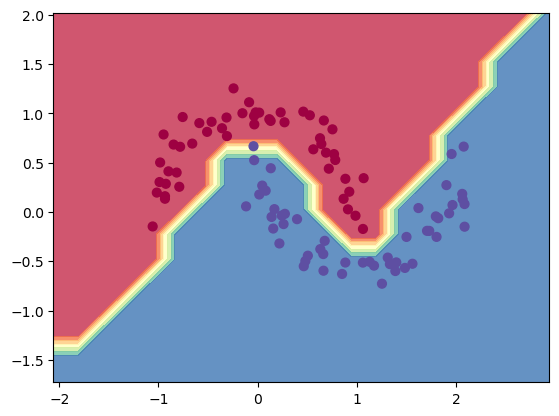